In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import sys

In [2]:
(x_train,_),(__,___) = tf.keras.datasets.mnist.load_data()
# scale input to -1 -> 1
data_set = (x_train-127.5)/127.5
data_set = data_set.reshape([data_set.shape[0],-1])

In [3]:
class data:
    def __init__(self,dataset,batch_size):
        self.dataset = dataset
        self.size = len(dataset)
        self.bs = batch_size
        self.lower = 0
        self.upper = 0
        self.batch_count = 0
        self.total_batches = 0
        self.low_up = []
        self.create_batch()
        
    def create_batch(self):
        while (self.upper<self.size):
            self.upper = self.lower+self.bs
            if (self.upper > self.size):
                self.upper = self.size
            self.low_up.append((self.lower,self.upper))
            self.lower = self.upper
        self.total_batches = len(self.low_up)
    def get_batch(self):
        l,u = self.low_up[self.batch_count]
        batch = self.dataset[l:u]
        self.batch_count+=1
        if self.batch_count >= self.total_batches:
            self.batch_count = 0
        return batch

In [4]:
BATCH_SIZE = 512
latent_dims = 100
mydata = data(data_set,BATCH_SIZE)

In [5]:
# Generator
def generator(z):
    with tf.variable_scope('generator'):
        #256 filters layer kernel size 7*7
        x = tf.layers.Dense(256)(z)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.Dense(256)(x)
        x = tf.layers.BatchNormalization()(x)
        x = x = tf.nn.leaky_relu(x)
        x = tf.layers.Dense(784)(x)
        x = tf.nn.tanh(x)
    return x

def discriminator(img):
    # reuse=tf.AUTO_REUSE make sure whenever we call discriminator function
    # tensorflow doesn't create another graph. ***VERY IMPORTANT***
    with tf.variable_scope('discriminator',reuse=tf.AUTO_REUSE):
        x = tf.layers.Dense(256)(img)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.Dropout(0.3)(x)
        x = tf.layers.Dense(128)(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.Dropout(0.3)(x)
        x = tf.layers.Dense(32)(x)
        x = tf.layers.BatchNormalization()(x)
        x = tf.nn.leaky_relu(x)
        x = tf.layers.Dense(1)(x)
        x = tf.nn.sigmoid(x)
    return x

In [6]:
tf.reset_default_graph()

In [7]:
z = tf.placeholder(name='z',shape=(None,latent_dims),dtype=tf.float32)
x = tf.placeholder(name="x",shape=(None,784),dtype=tf.float32)

In [8]:
fake_img = generator(z)
fake_pred = discriminator(fake_img)
real_pred= discriminator(x)

dis_loss_real = tf.losses.mean_squared_error(tf.ones_like(real_pred),real_pred)
dis_loss_fake = tf.losses.mean_squared_error(tf.zeros_like(fake_pred),fake_pred)

gen_loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(tf.ones_like(fake_pred),fake_pred))
dis_loss = tf.reduce_mean(dis_loss_fake+dis_loss_real)

In [9]:
gen_variable = [v for v in tf.trainable_variables() if v.name.startswith('generator')]
dis_variable = [v for v in tf.trainable_variables() if v.name.startswith('discriminator')]
gen_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in gen_variable])
dis_var_count = np.sum([np.prod(v.get_shape().as_list()) for v in dis_variable])
print("gen_var_count:",gen_var_count)
print("dis_var_count:",dis_var_count)
print("total:",gen_var_count+dis_var_count)

gen_var_count: 294160
dis_var_count: 238849
total: 533009


In [10]:
dis_op = tf.train.AdamOptimizer(0.0001)
dis_train = dis_op.minimize(dis_loss,var_list=dis_variable)

# var_list: make sure an optimizer only optimize given variable.

gen_op = tf.train.AdamOptimizer(0.0001)
gen_train = gen_op.minimize(gen_loss, var_list=gen_variable)

init = tf.global_variables_initializer()

In [11]:
disLoss_his = []
genLoss_his = []
sess = tf.Session()

In [12]:
sess.run(init)

In [13]:
test_noise = np.random.normal(size=[10,latent_dims])
def show_sample(noise):
    fig = plt.figure()
    plt.set_cmap('gray')
    imgs = sess.run(fake_img,feed_dict={z:noise})
    h = 2
    w = 5
    c = 1
    for i in imgs:
        i = i.reshape(28,28)
        i = i*127.5+127.5
        plt.subplots_adjust(left=None, bottom=0.7, right=2, top=2, wspace=None, hspace=0)
        plt.subplot(h,w,c)
        plt.imshow(i)
        plt.axis('off')
        c+=1

Epoch 0: gl_loss = 0.5652385950088501, dl_loss =0.08997996151447296


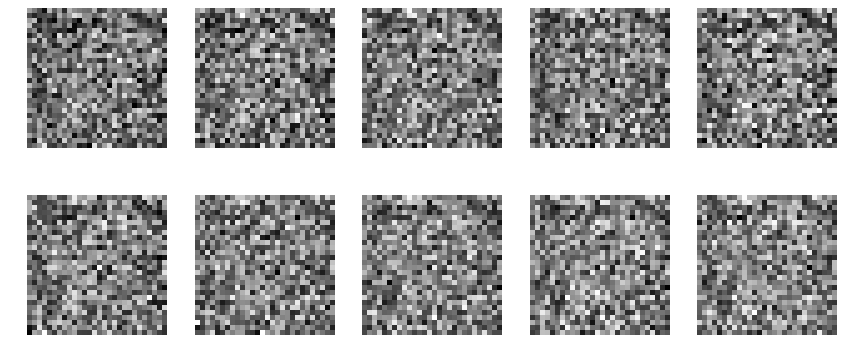

Epoch 1: gl_loss = 0.605292797088623, dl_loss =0.03800712525844574


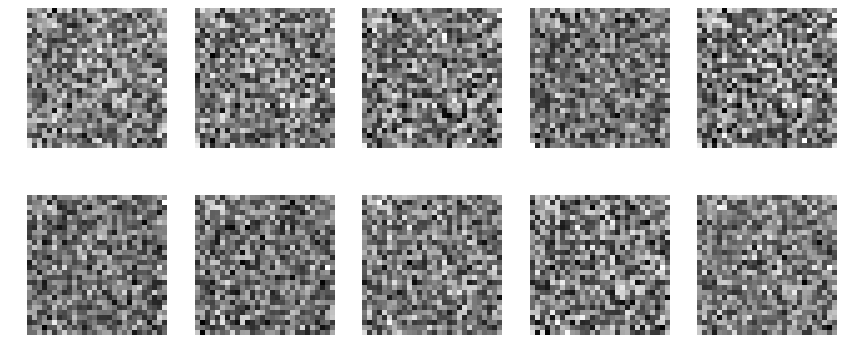

Epoch 2: gl_loss = 0.621575117111206, dl_loss =0.02741699293255806


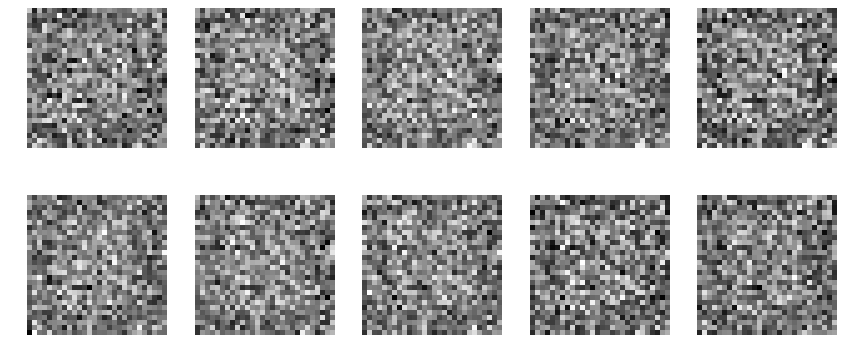

Epoch 3: gl_loss = 0.6366772651672363, dl_loss =0.022075822576880455


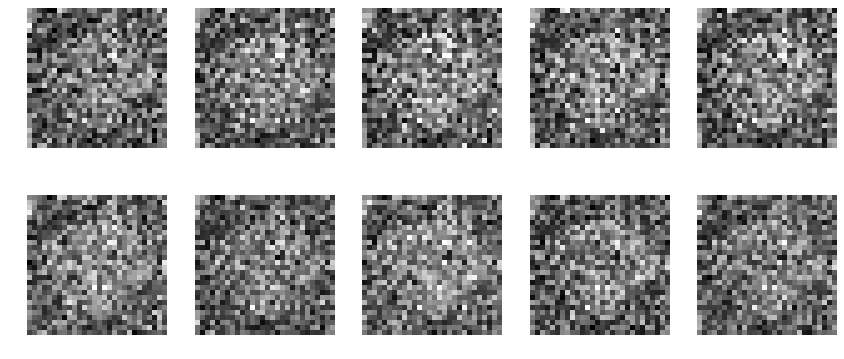

Epoch 4: gl_loss = 0.6421058177947998, dl_loss =0.020430220291018486


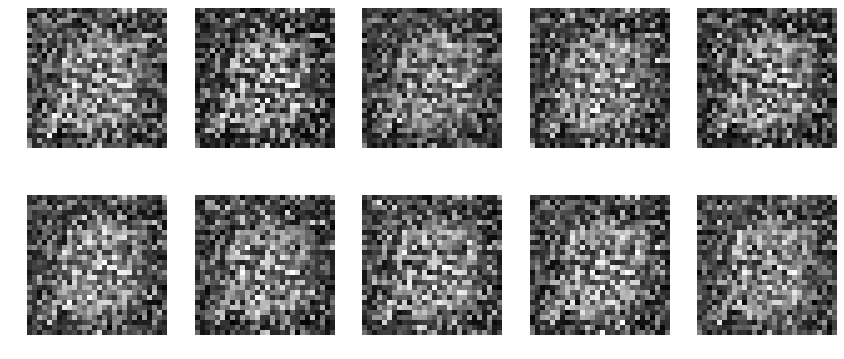

Epoch 5: gl_loss = 0.64409339427948, dl_loss =0.028723228722810745


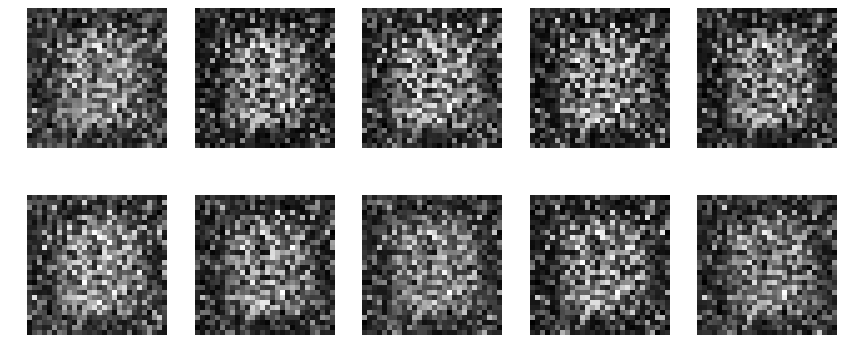

Epoch 6: gl_loss = 0.632248044013977, dl_loss =0.0420922189950943


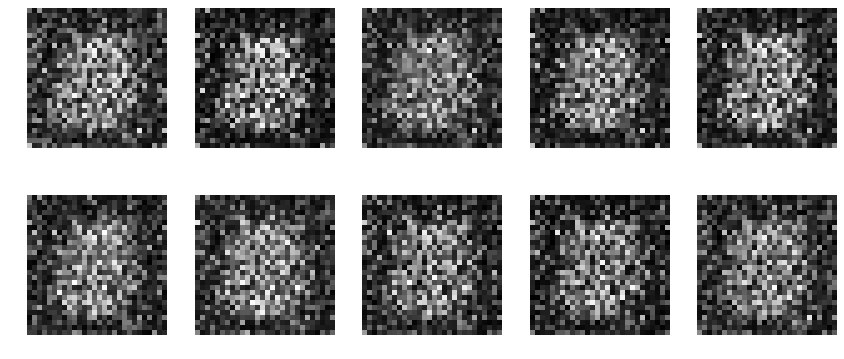

Epoch 7: gl_loss = 0.6579698920249939, dl_loss =0.058304764330387115


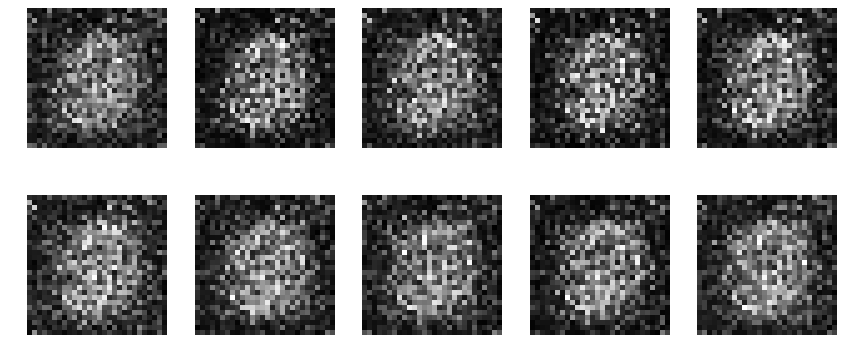

Epoch 8: gl_loss = 0.6686174273490906, dl_loss =0.012347748503088951


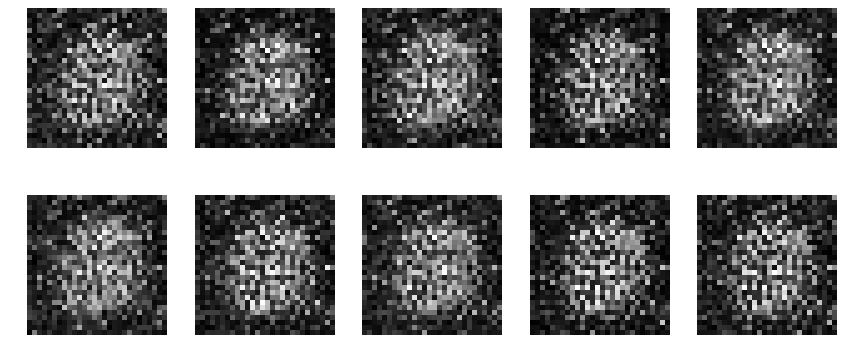

Epoch 9: gl_loss = 0.6234607696533203, dl_loss =0.1788751184940338


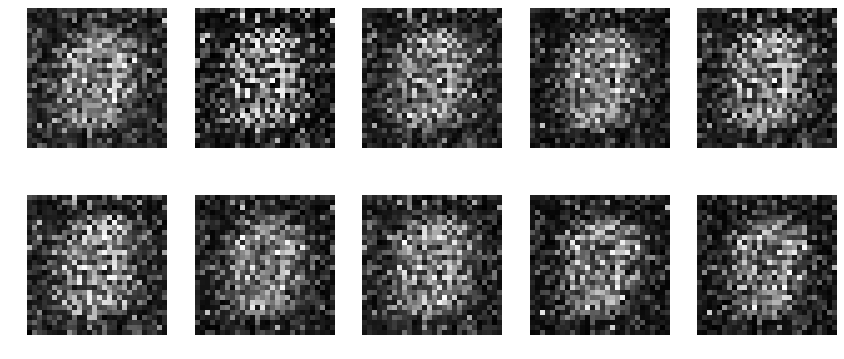

Epoch 10: gl_loss = 0.6143925189971924, dl_loss =0.1466052234172821


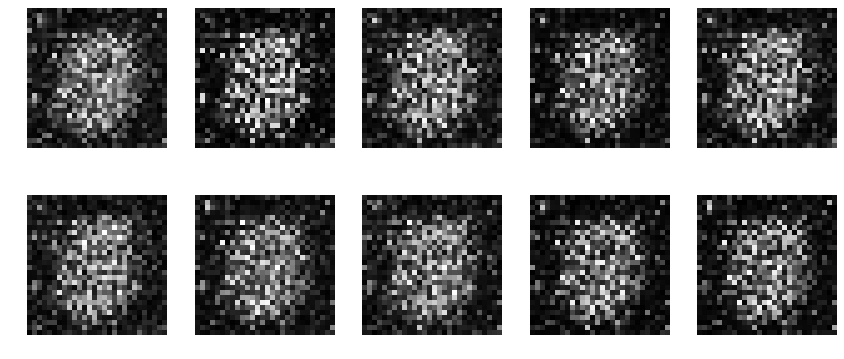

Epoch 11: gl_loss = 0.6864351034164429, dl_loss =0.006459762807935476


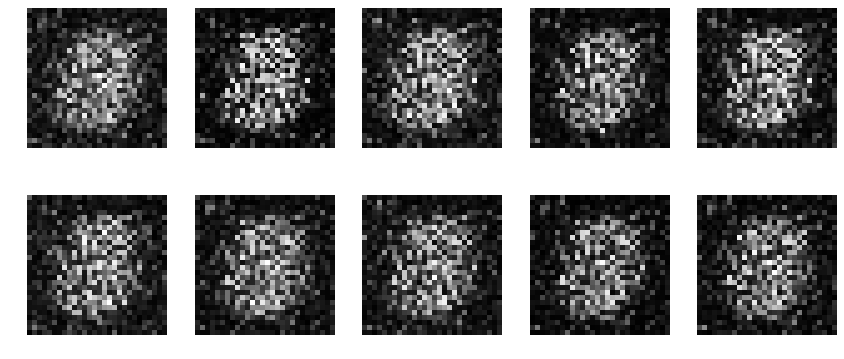

Epoch 12: gl_loss = 0.6805497407913208, dl_loss =0.014003470540046692


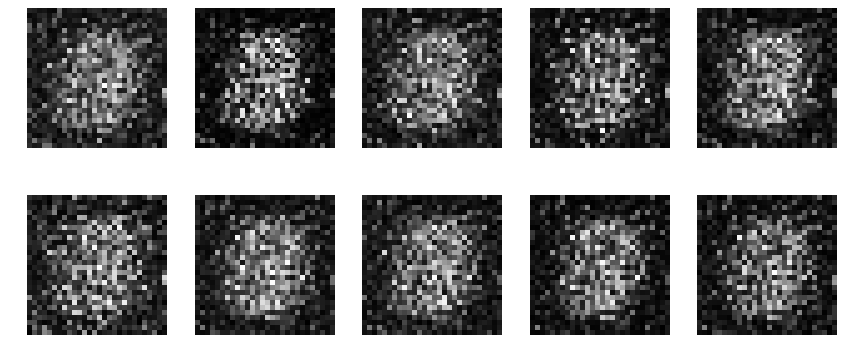

Epoch 13: gl_loss = 0.6225572824478149, dl_loss =0.1303187608718872


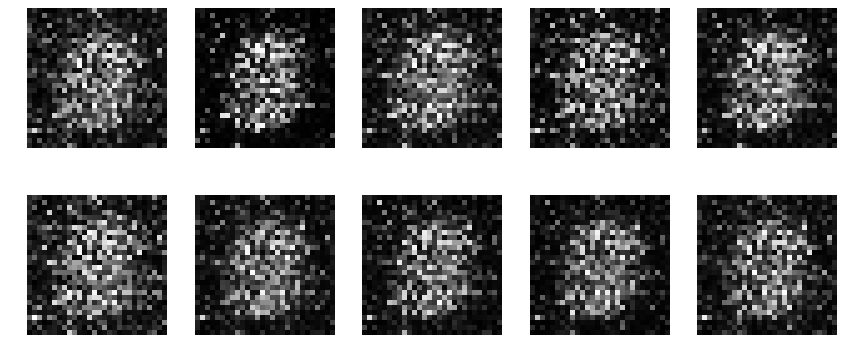

Epoch 14: gl_loss = 0.6652866005897522, dl_loss =0.03438873961567879


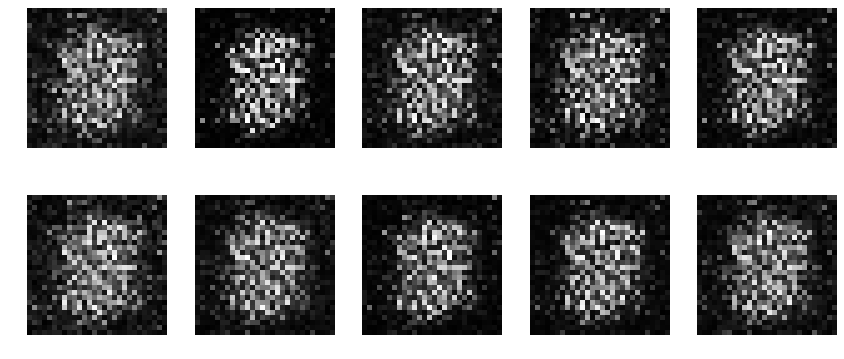

Epoch 15: gl_loss = 0.6828622221946716, dl_loss =0.014851695857942104


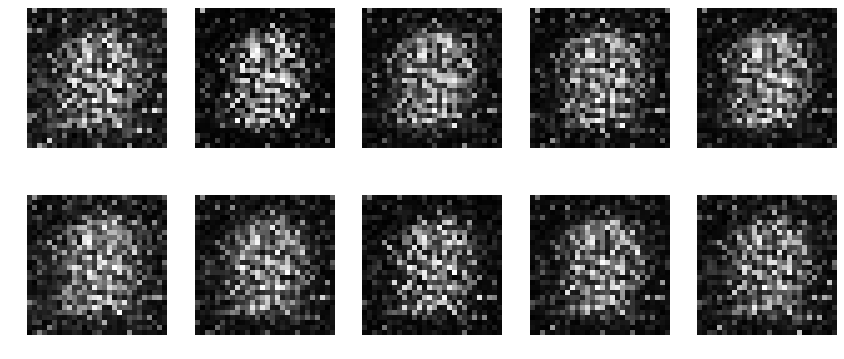

Epoch 16: gl_loss = 0.6659606695175171, dl_loss =0.03510408103466034


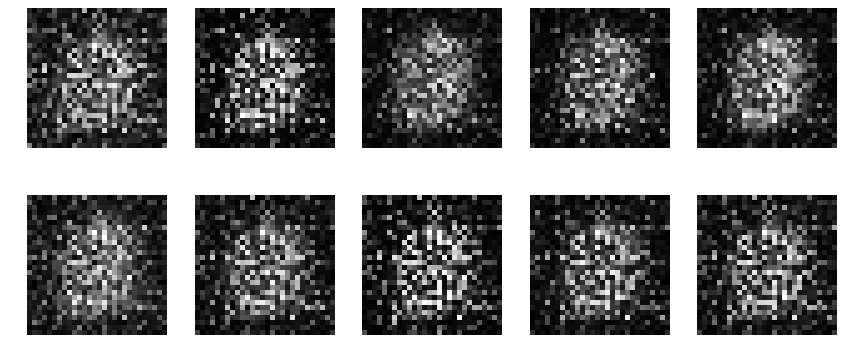

Epoch 17: gl_loss = 0.6107043623924255, dl_loss =0.24686822295188904


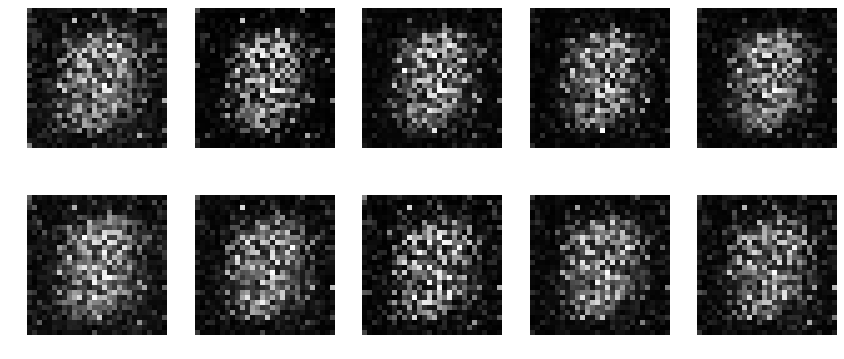

Epoch 18: gl_loss = 0.6643785238265991, dl_loss =0.043546173721551895


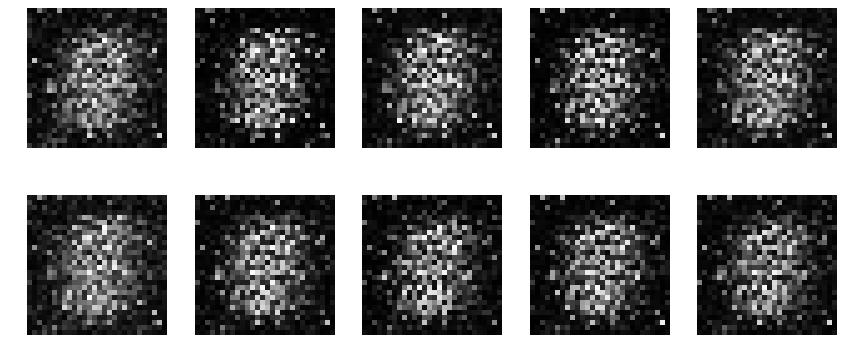

Epoch 19: gl_loss = 0.6712617874145508, dl_loss =0.025335215032100677


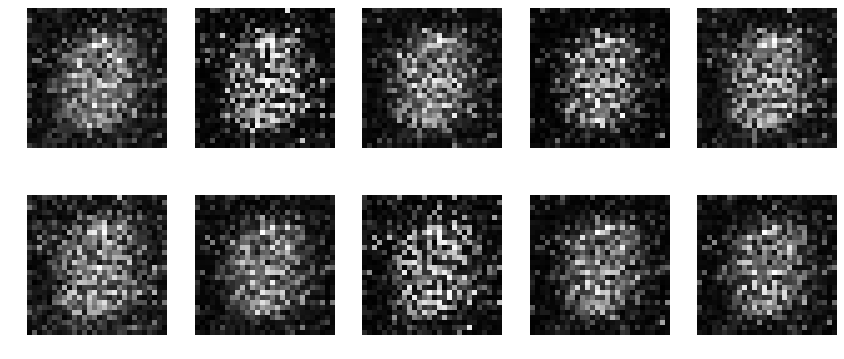

Epoch 20: gl_loss = 0.6687463521957397, dl_loss =0.026034079492092133


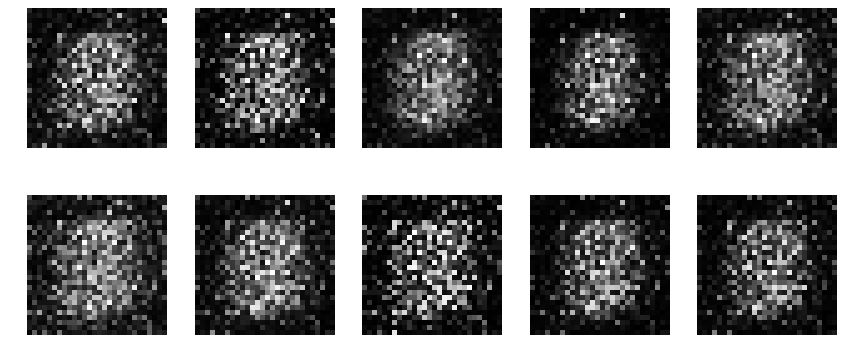

Epoch 21: gl_loss = 0.626510500907898, dl_loss =0.18966980278491974


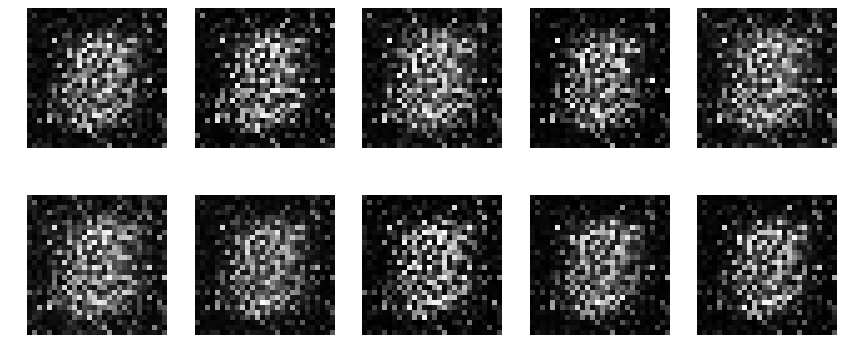

Epoch 22: gl_loss = 0.6778275966644287, dl_loss =0.009396811947226524


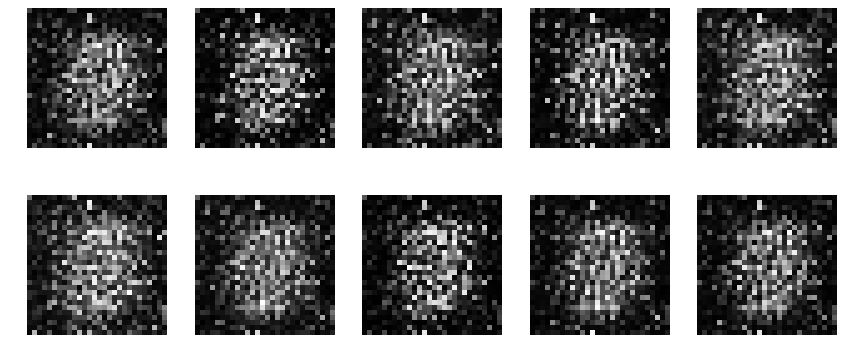

Epoch 23: gl_loss = 0.6574081182479858, dl_loss =0.03473089262843132


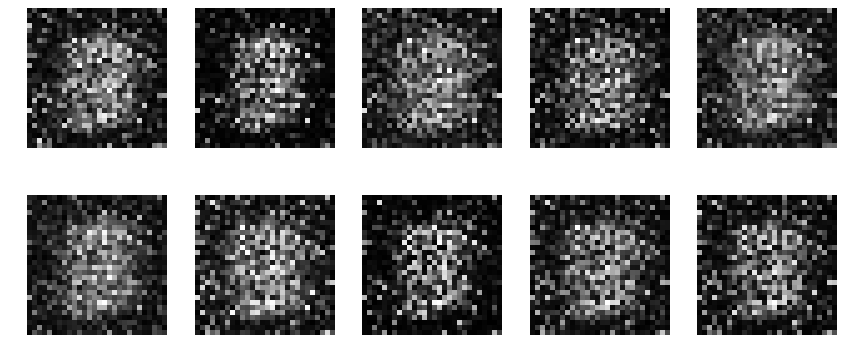

Epoch 24: gl_loss = 0.6338735222816467, dl_loss =0.12419518083333969


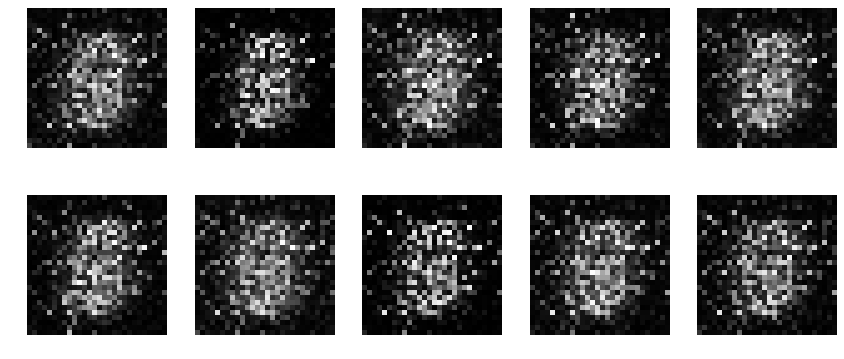

Epoch 25: gl_loss = 0.6469200253486633, dl_loss =0.10218235850334167


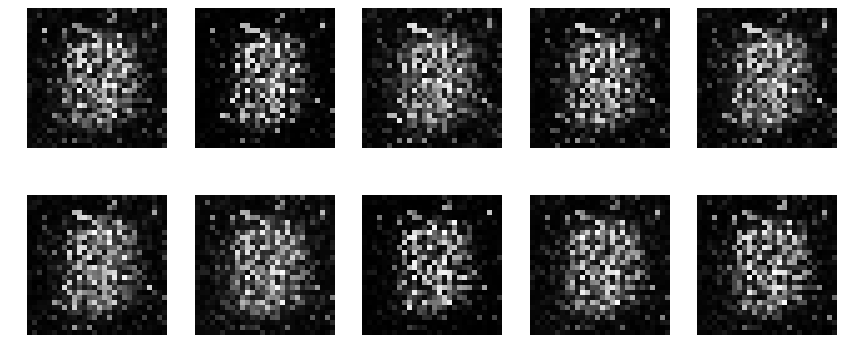

Epoch 26: gl_loss = 0.6794083118438721, dl_loss =0.023242846131324768


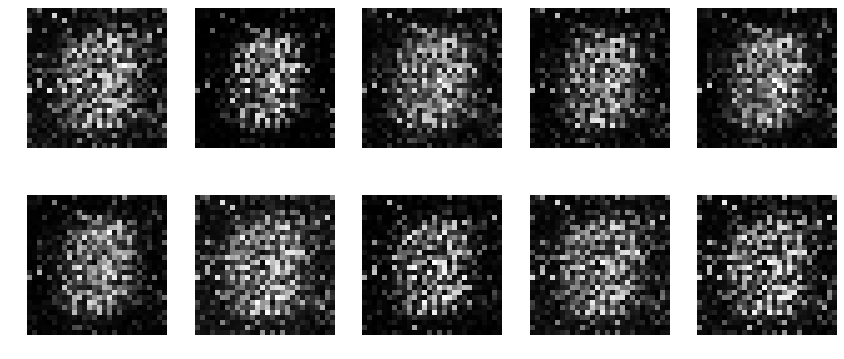

Epoch 27: gl_loss = 0.6233358979225159, dl_loss =0.13870996236801147


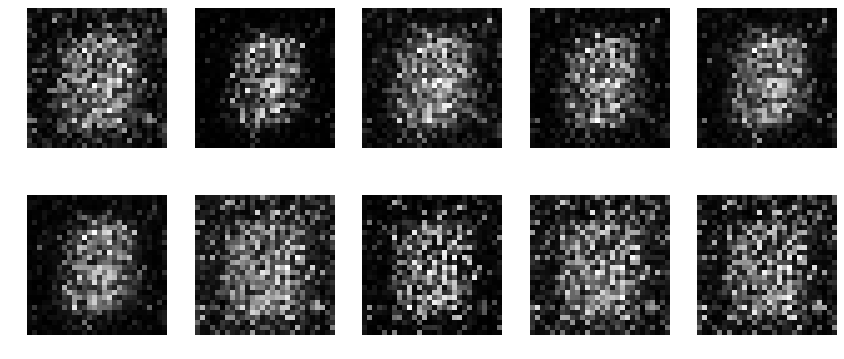

Epoch 28: gl_loss = 0.6368653178215027, dl_loss =0.10774882137775421


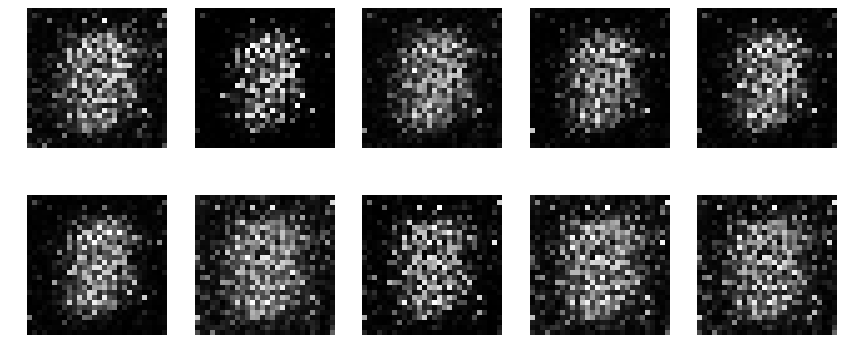

Epoch 29: gl_loss = 0.6843892931938171, dl_loss =0.022722529247403145


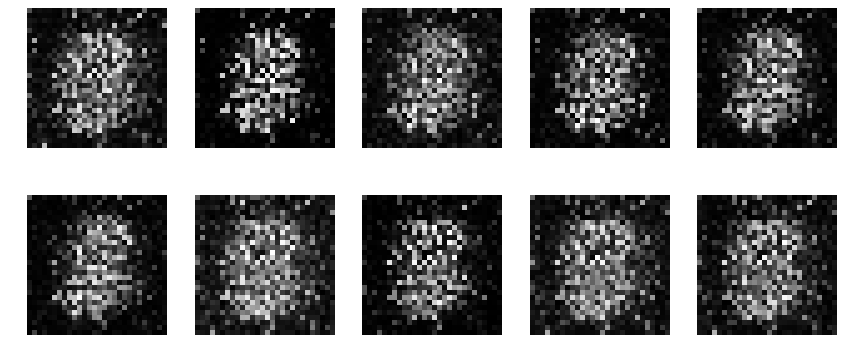

Epoch 30: gl_loss = 0.6828936338424683, dl_loss =0.04546334594488144


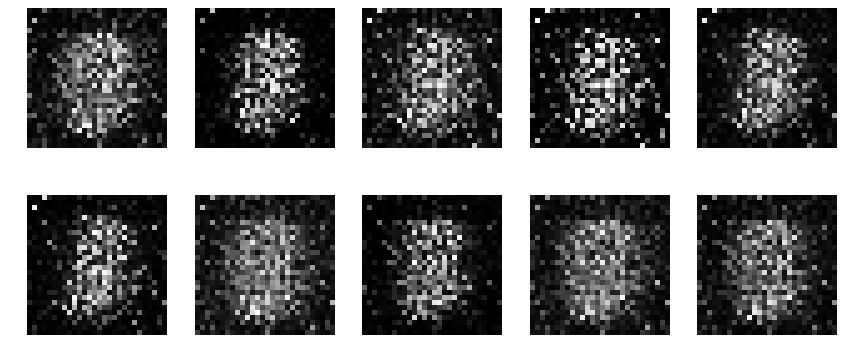

Epoch 31: gl_loss = 0.667970597743988, dl_loss =0.062201306223869324


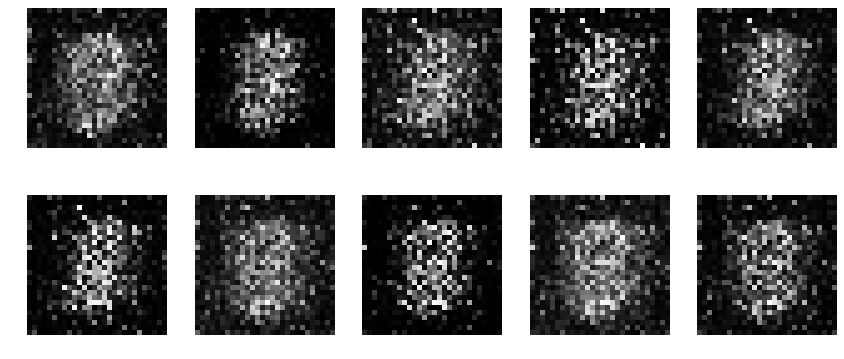

Epoch 32: gl_loss = 0.6560456156730652, dl_loss =0.06945665925741196


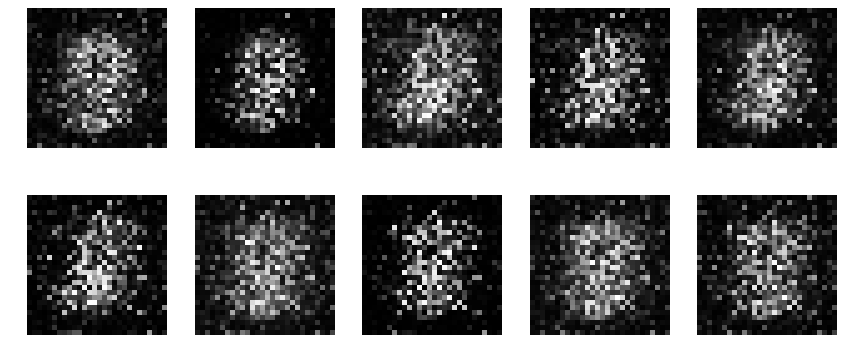

Epoch 33: gl_loss = 0.6658583879470825, dl_loss =0.06202328950166702


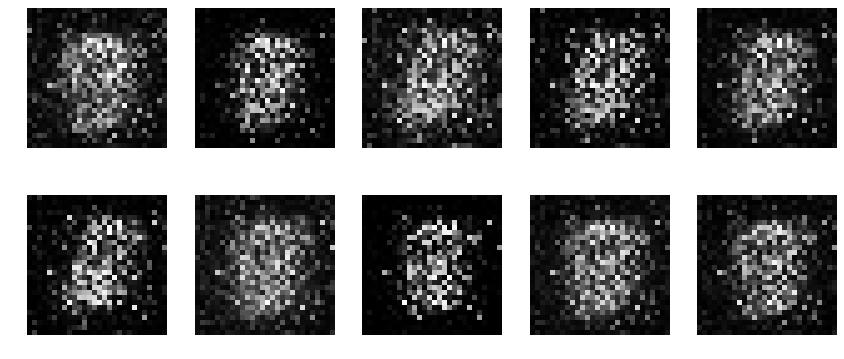

Epoch 34: gl_loss = 0.6426488757133484, dl_loss =0.05519922822713852


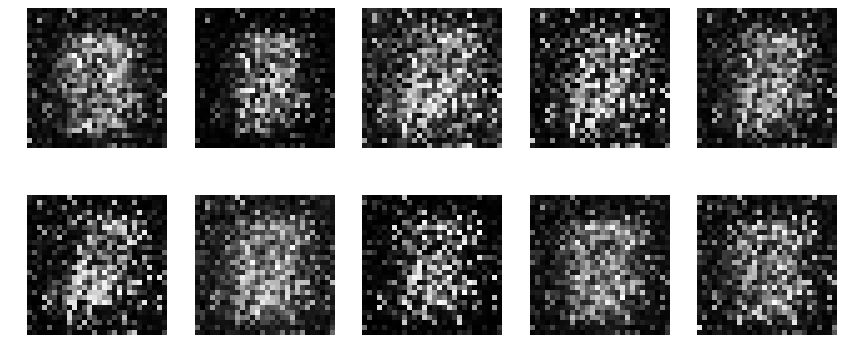

Epoch 35: gl_loss = 0.6642749905586243, dl_loss =0.05282221734523773


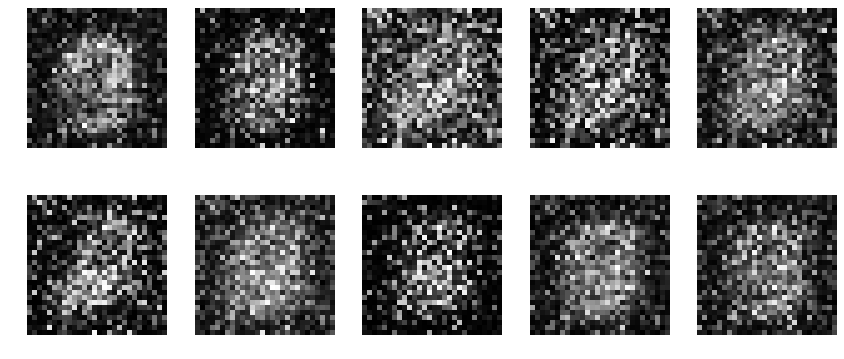

Epoch 36: gl_loss = 0.6676640510559082, dl_loss =0.12650395929813385


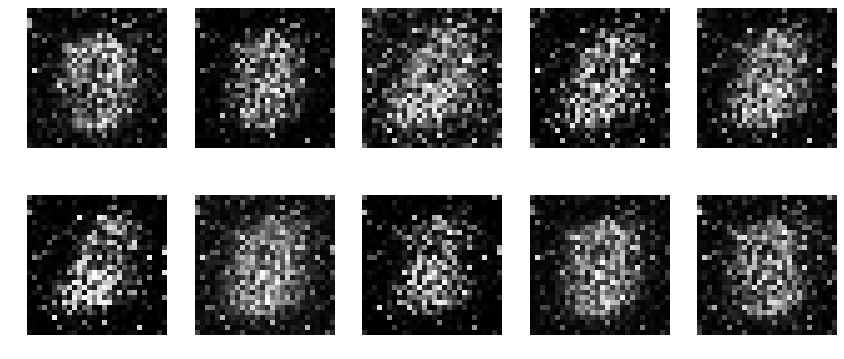

Epoch 37: gl_loss = 0.6660679578781128, dl_loss =0.1579568088054657


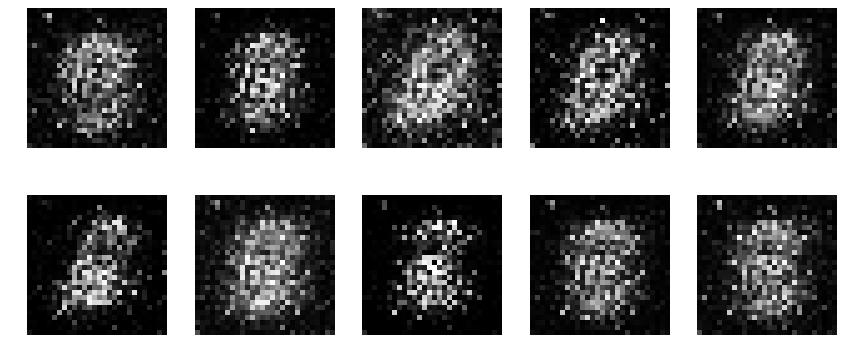

Epoch 38: gl_loss = 0.6325192451477051, dl_loss =0.10449223220348358


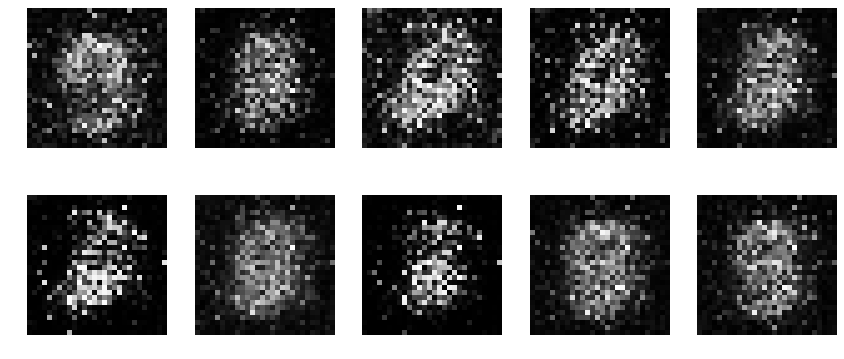

Epoch 39: gl_loss = 0.6743567585945129, dl_loss =0.03336884081363678


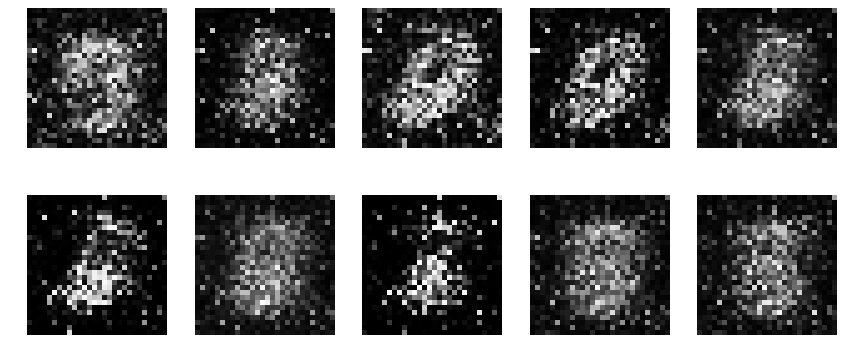

Epoch 40: gl_loss = 0.6419974565505981, dl_loss =0.1537170708179474


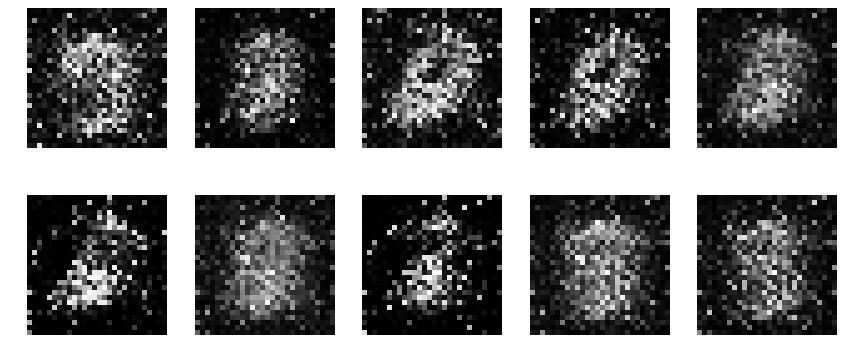

Epoch 41: gl_loss = 0.6643149256706238, dl_loss =0.09181112051010132


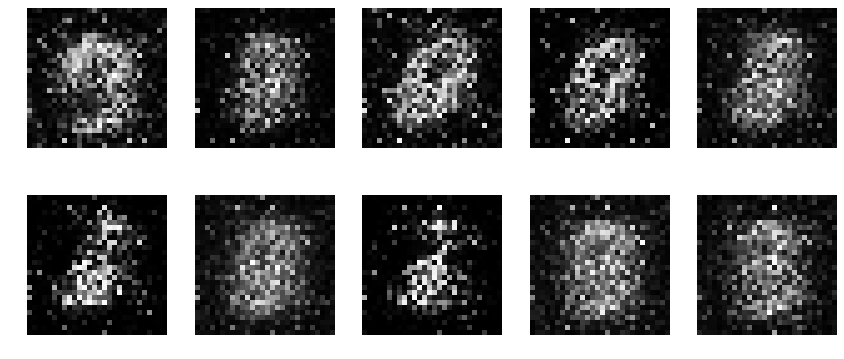

Epoch 42: gl_loss = 0.6323437094688416, dl_loss =0.16173133254051208


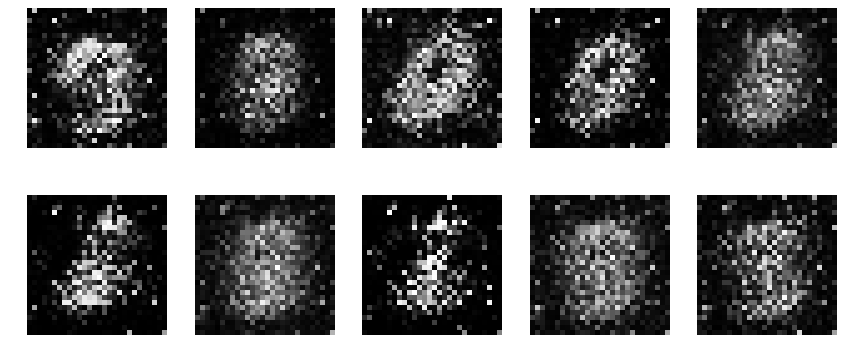

Epoch 43: gl_loss = 0.6691685318946838, dl_loss =0.04399773105978966


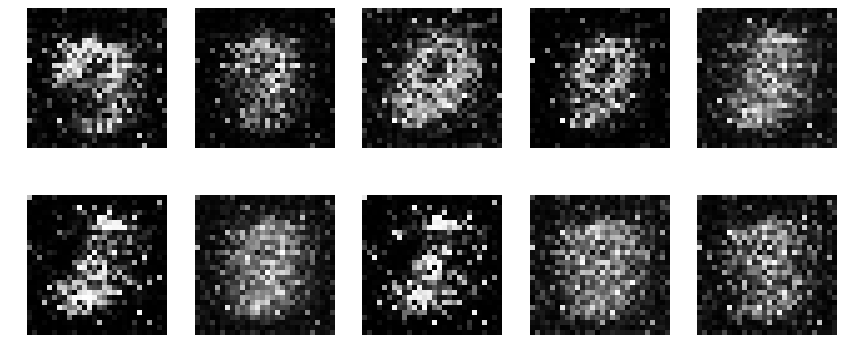

Epoch 44: gl_loss = 0.6334531307220459, dl_loss =0.06064142286777496


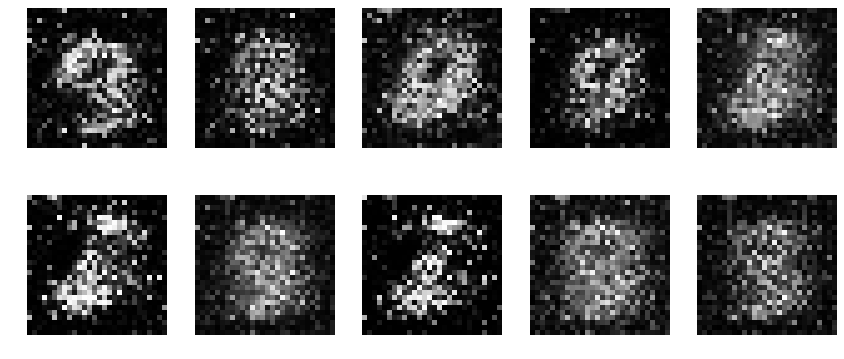

Epoch 45: gl_loss = 0.6505073308944702, dl_loss =0.1500677615404129


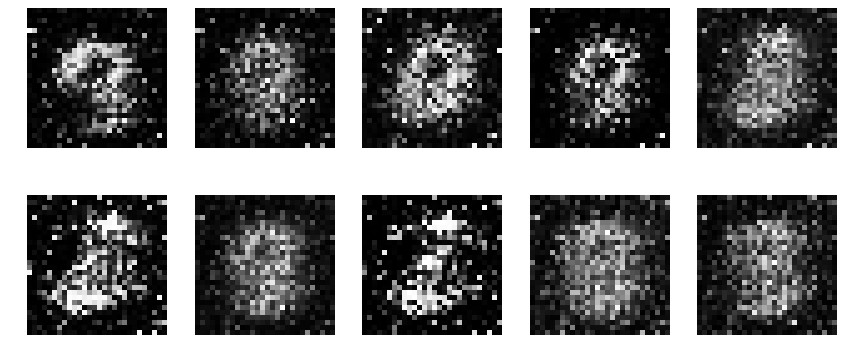

Epoch 46: gl_loss = 0.6556729674339294, dl_loss =0.10853905975818634


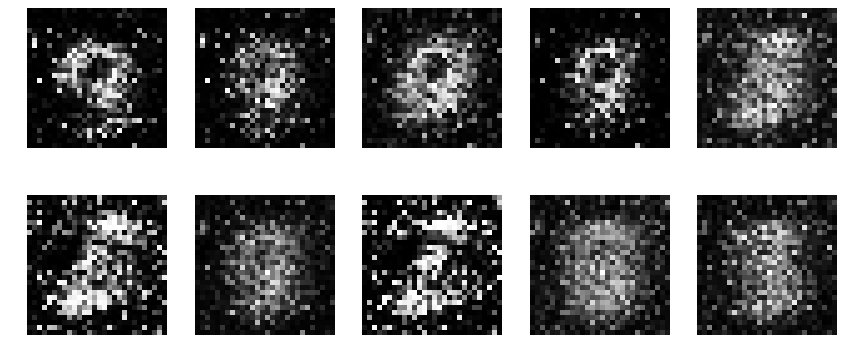

Epoch 47: gl_loss = 0.6569925546646118, dl_loss =0.04685138911008835


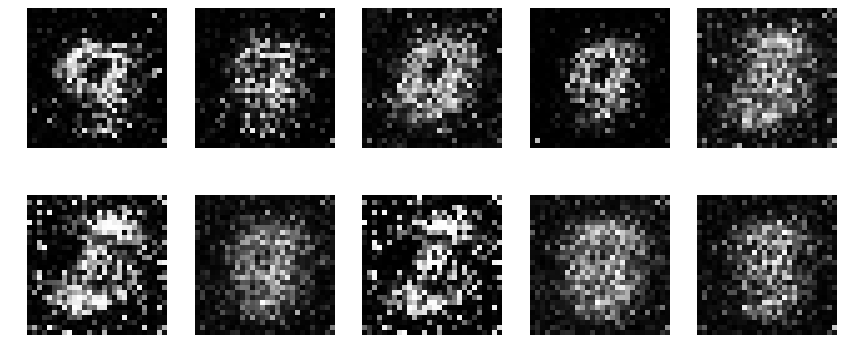

Epoch 48: gl_loss = 0.6427034139633179, dl_loss =0.07398517429828644


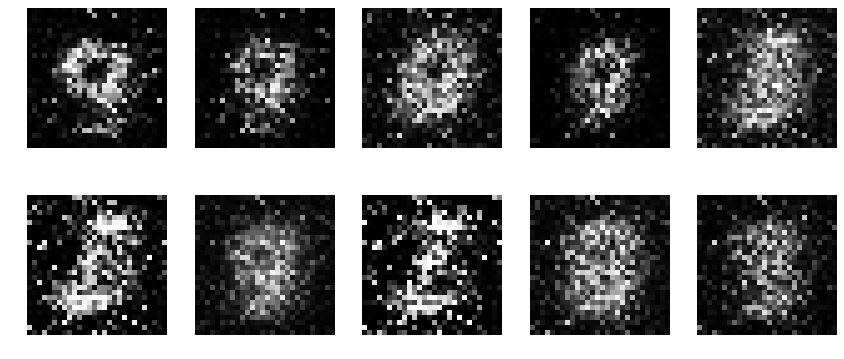

Epoch 49: gl_loss = 0.6717545986175537, dl_loss =0.0349549725651741


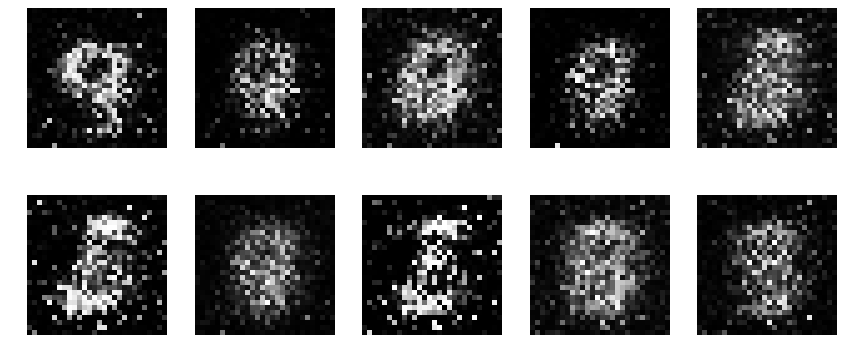

Epoch 50: gl_loss = 0.6775022149085999, dl_loss =0.017140783369541168


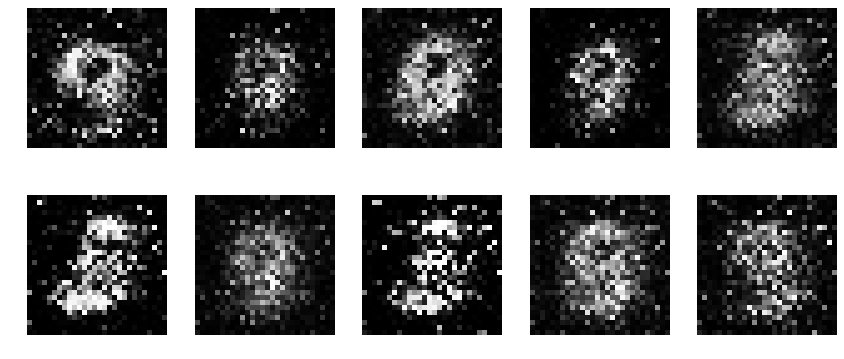

Epoch 51: gl_loss = 0.6640130281448364, dl_loss =0.10179506987333298


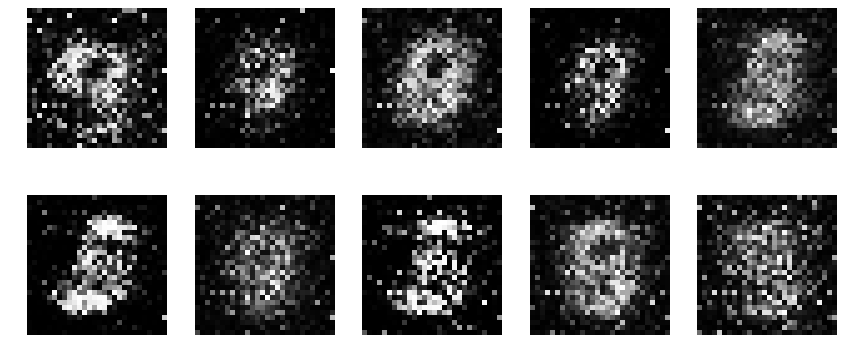

Epoch 52: gl_loss = 0.6814348697662354, dl_loss =0.05514828860759735


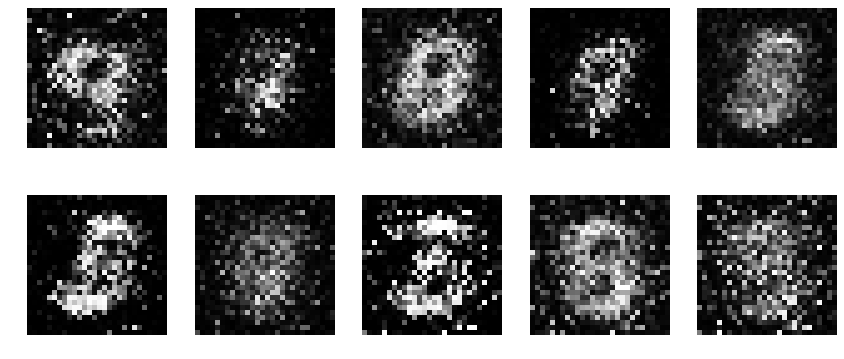

Epoch 53: gl_loss = 0.6523164510726929, dl_loss =0.04556941241025925


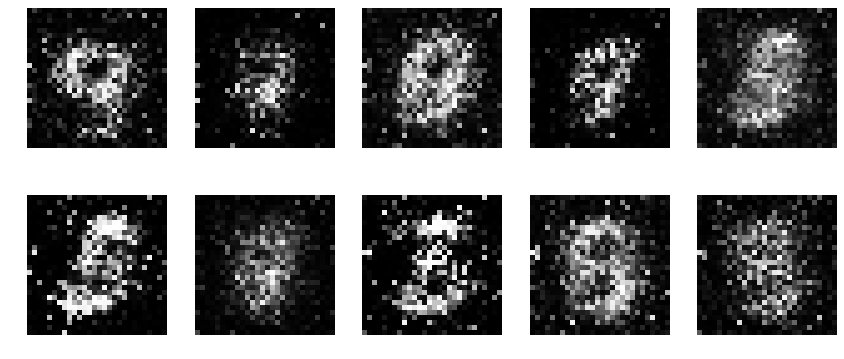

Epoch 54: gl_loss = 0.671091616153717, dl_loss =0.11554607003927231


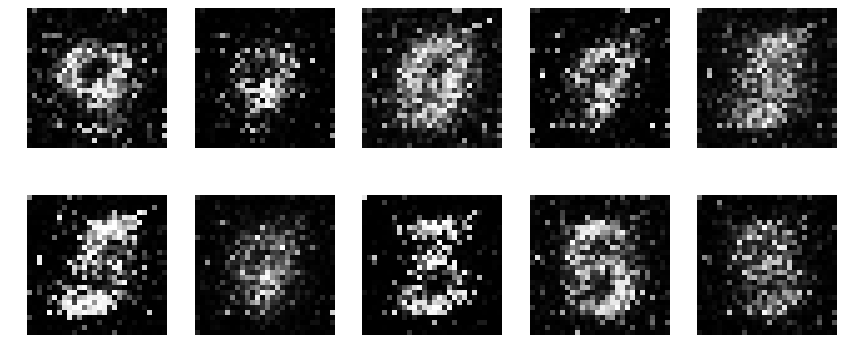

Epoch 55: gl_loss = 0.6656081676483154, dl_loss =0.07052087783813477


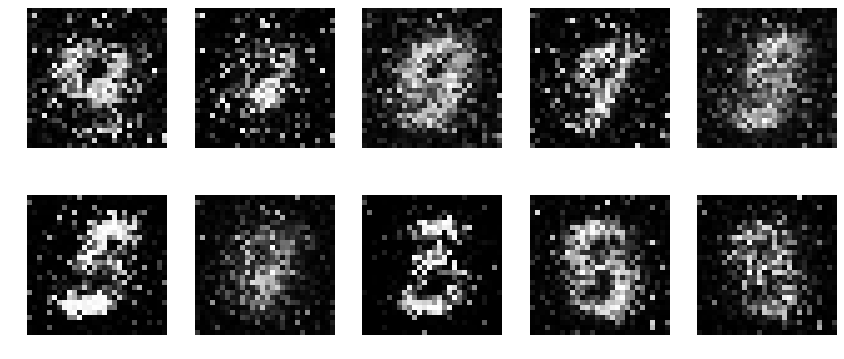

Epoch 56: gl_loss = 0.6686433553695679, dl_loss =0.03797402232885361


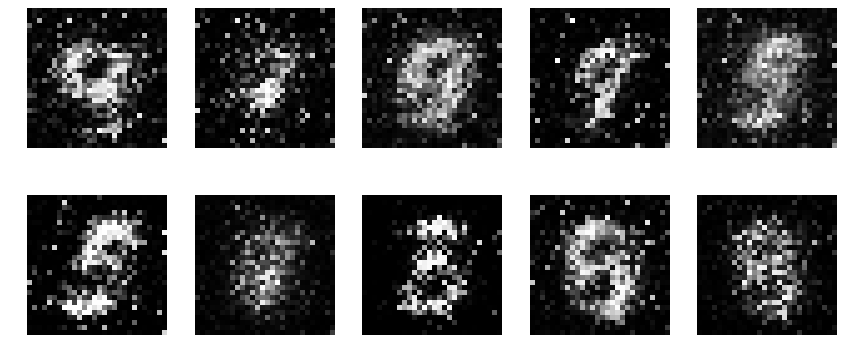

Epoch 57: gl_loss = 0.6590254306793213, dl_loss =0.0541764497756958


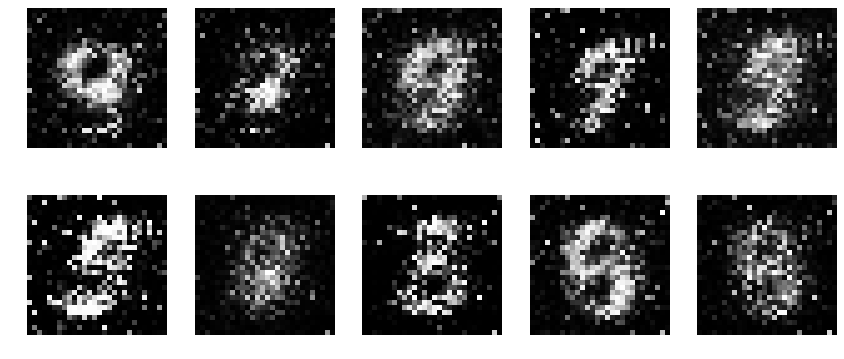

Epoch 58: gl_loss = 0.667941689491272, dl_loss =0.045978765934705734


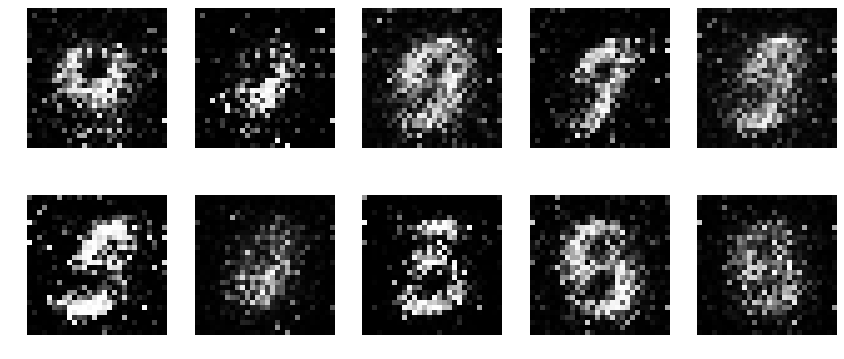

Epoch 59: gl_loss = 0.6741034984588623, dl_loss =0.14327140152454376


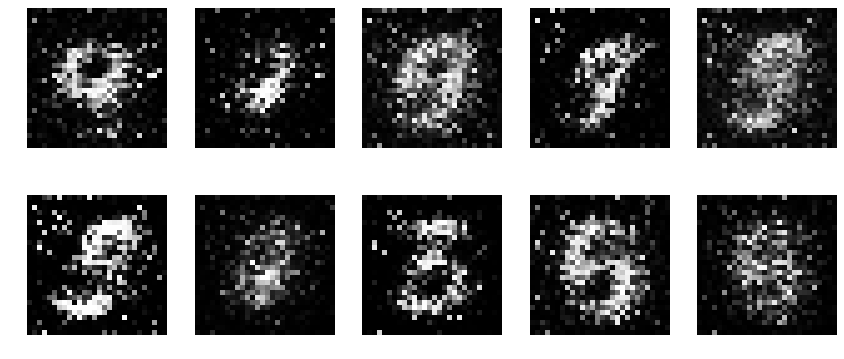

Epoch 60: gl_loss = 0.667046844959259, dl_loss =0.036956921219825745


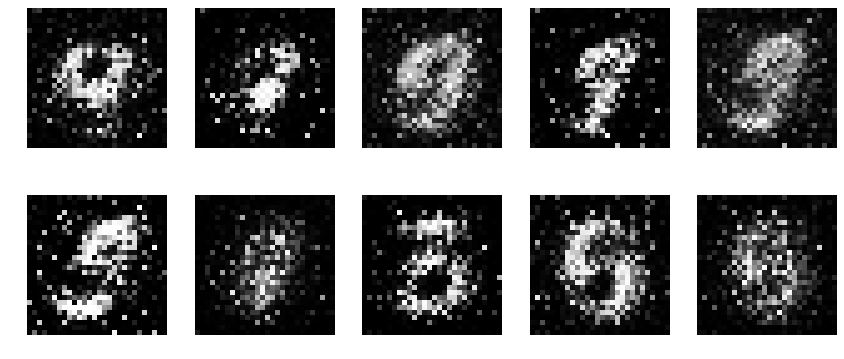

Epoch 61: gl_loss = 0.6615928411483765, dl_loss =0.034703031182289124


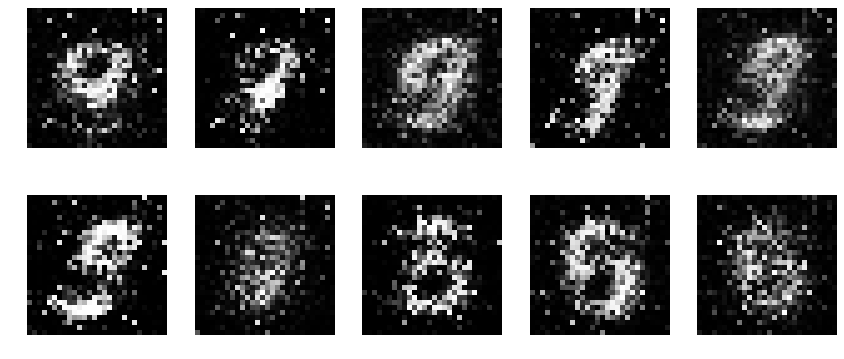

Epoch 62: gl_loss = 0.6470832228660583, dl_loss =0.14616623520851135


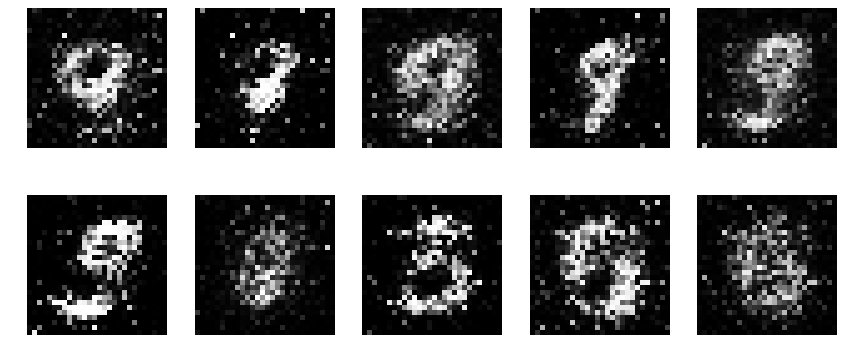

Epoch 63: gl_loss = 0.6671818494796753, dl_loss =0.05349154397845268


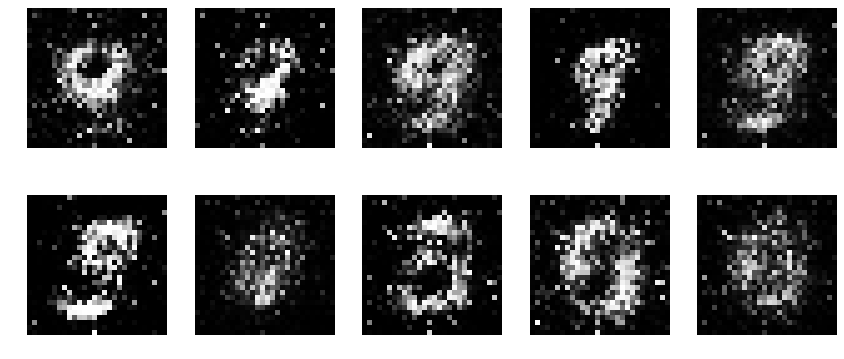

Epoch 64: gl_loss = 0.6753453612327576, dl_loss =0.12262190133333206


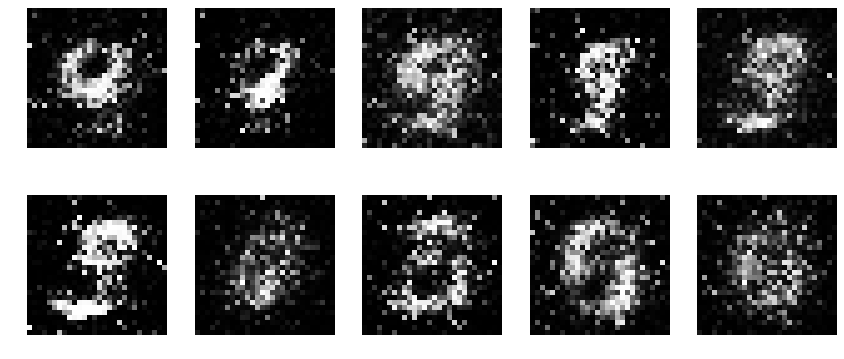

Epoch 65: gl_loss = 0.6611096262931824, dl_loss =0.05244266614317894


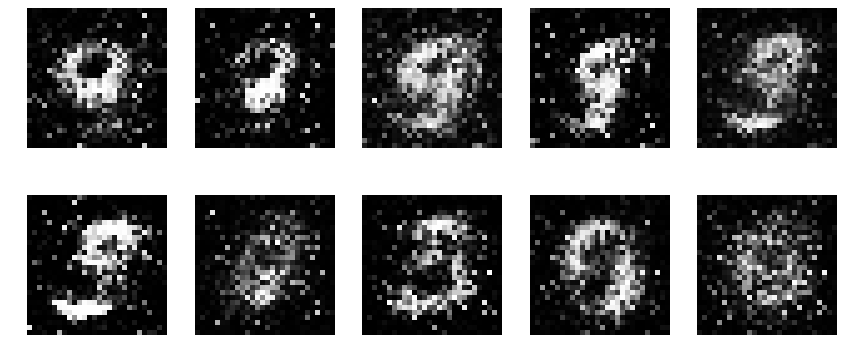

Epoch 66: gl_loss = 0.6440976858139038, dl_loss =0.08337849378585815


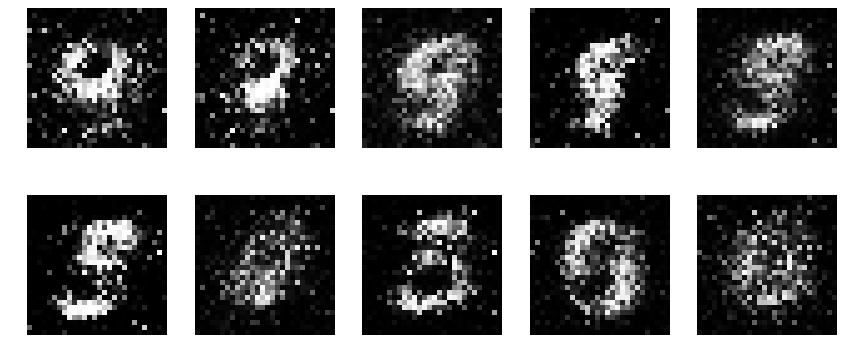

Epoch 67: gl_loss = 0.6559851169586182, dl_loss =0.1347854733467102


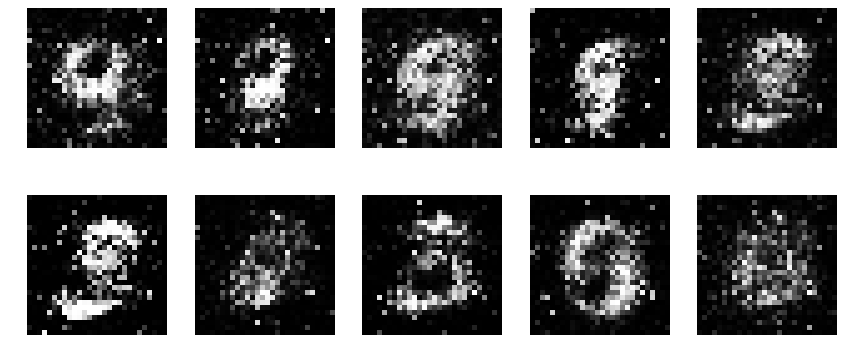

Epoch 68: gl_loss = 0.6643519401550293, dl_loss =0.08053727447986603


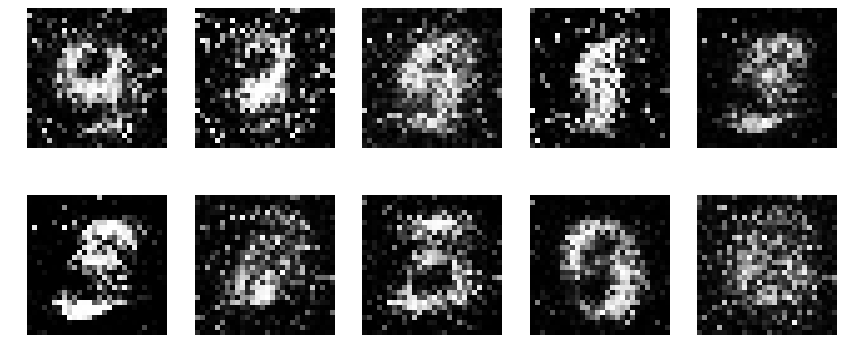

Epoch 69: gl_loss = 0.6529827117919922, dl_loss =0.10468320548534393


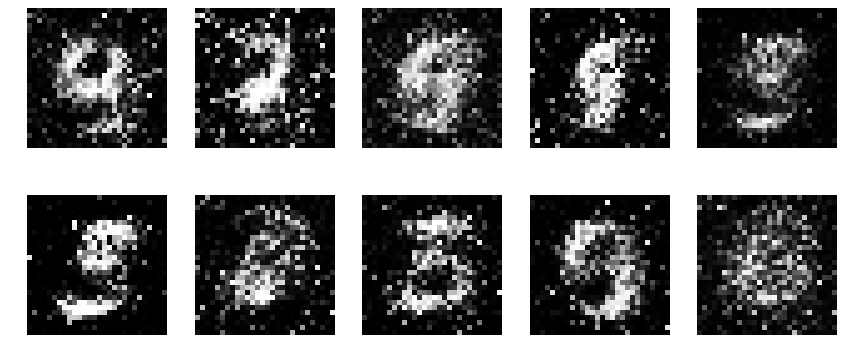

Epoch 70: gl_loss = 0.6643303632736206, dl_loss =0.04459897428750992


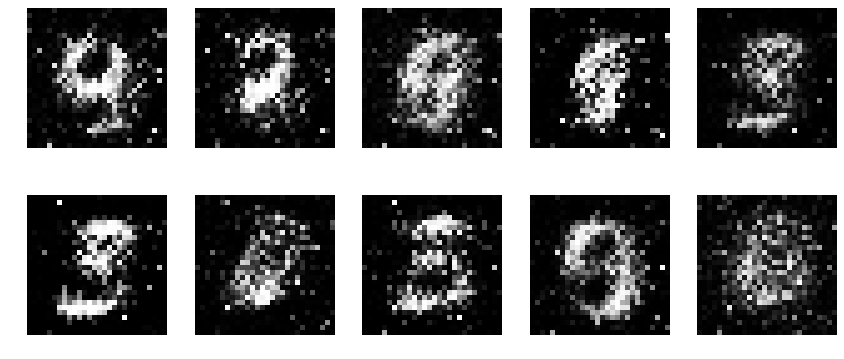

Epoch 71: gl_loss = 0.6583846807479858, dl_loss =0.24856358766555786


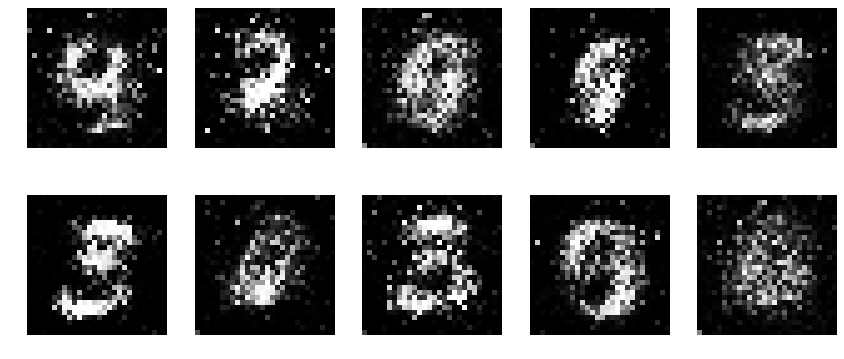

Epoch 72: gl_loss = 0.676618218421936, dl_loss =0.16951192915439606


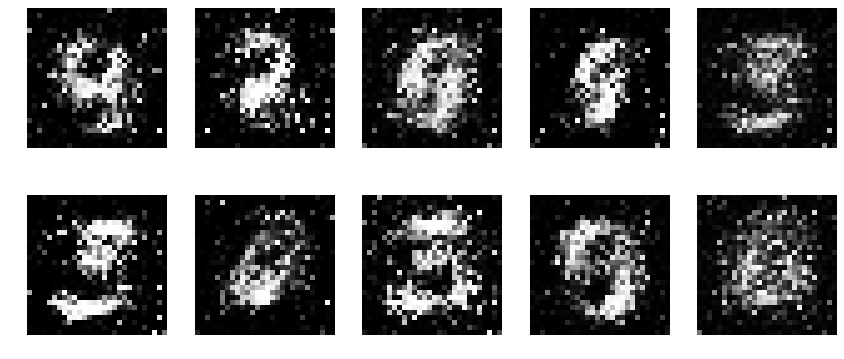

Epoch 73: gl_loss = 0.6606370210647583, dl_loss =0.07908593118190765


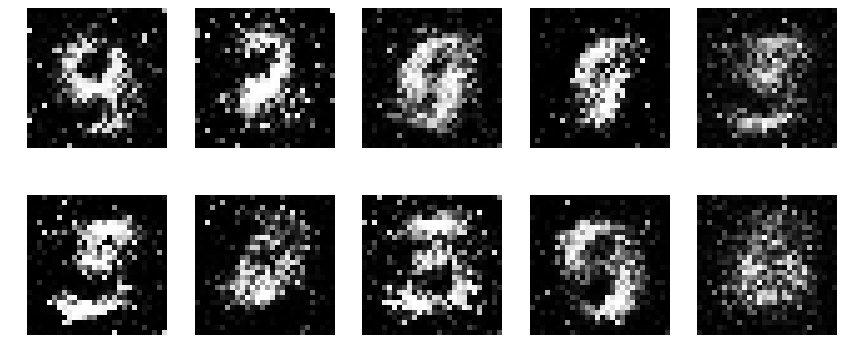

Epoch 74: gl_loss = 0.6292584538459778, dl_loss =0.13868245482444763


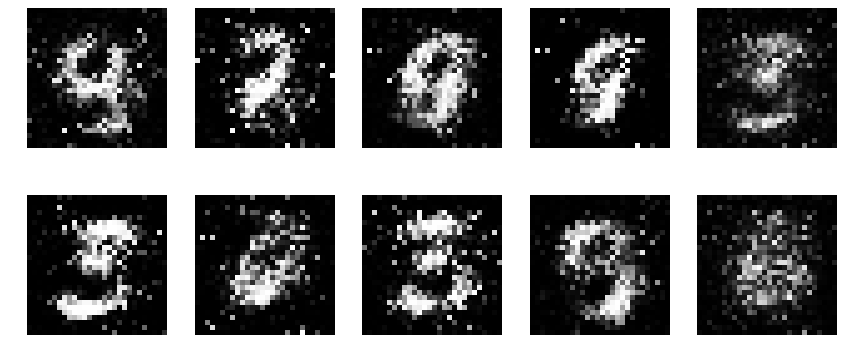

Epoch 75: gl_loss = 0.6531964540481567, dl_loss =0.07777050882577896


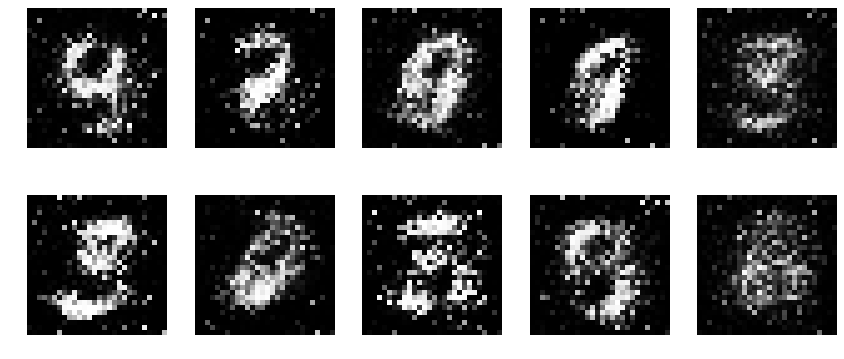

Epoch 76: gl_loss = 0.6694365739822388, dl_loss =0.050427306443452835


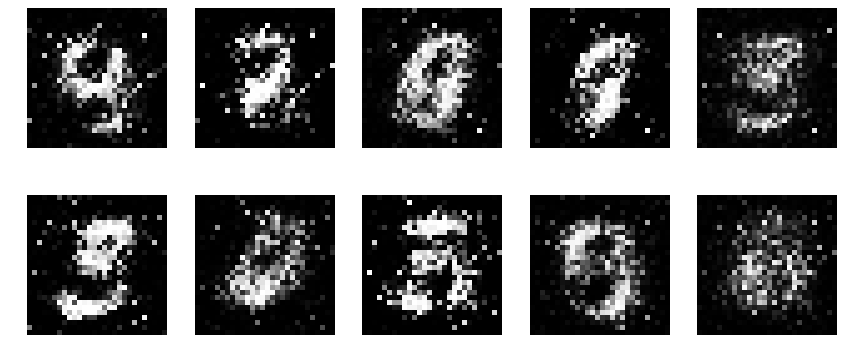

Epoch 77: gl_loss = 0.6557615399360657, dl_loss =0.05368196219205856


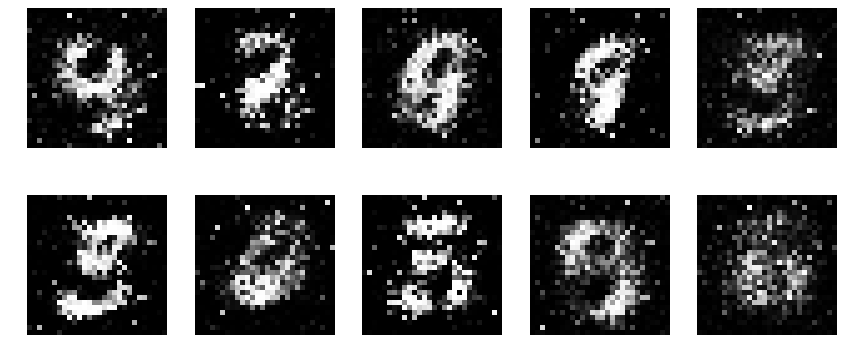

Epoch 78: gl_loss = 0.6526674032211304, dl_loss =0.11816734820604324


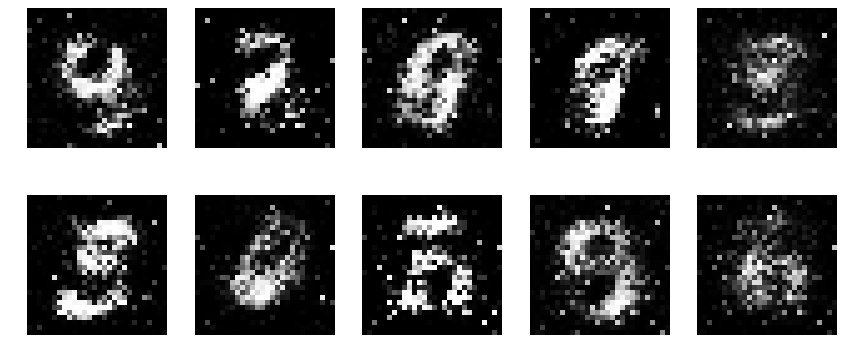

Epoch 79: gl_loss = 0.65326988697052, dl_loss =0.06839509308338165


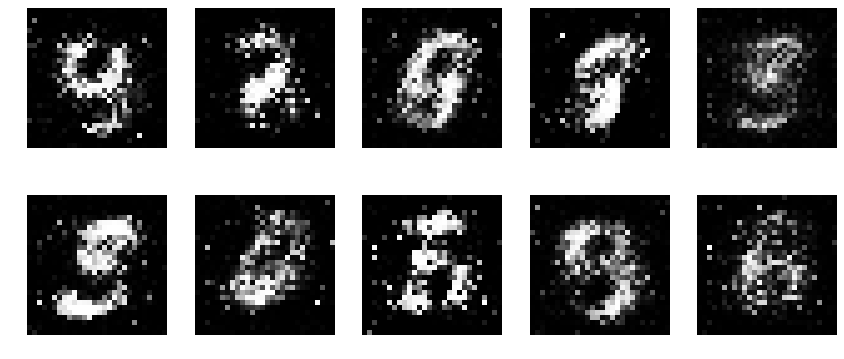

Epoch 80: gl_loss = 0.6764781475067139, dl_loss =0.038926392793655396


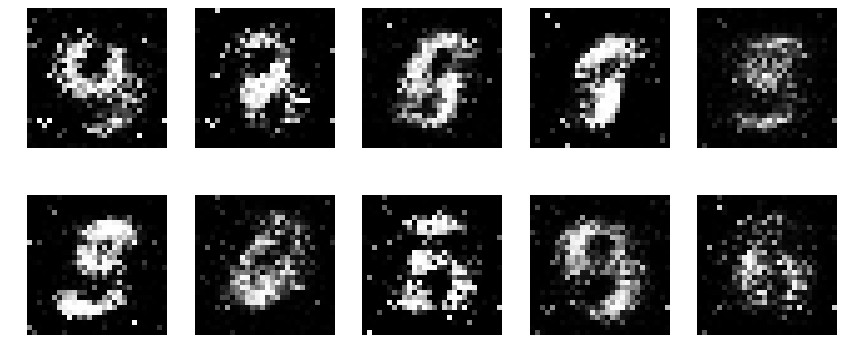

Epoch 81: gl_loss = 0.663957953453064, dl_loss =0.16813337802886963


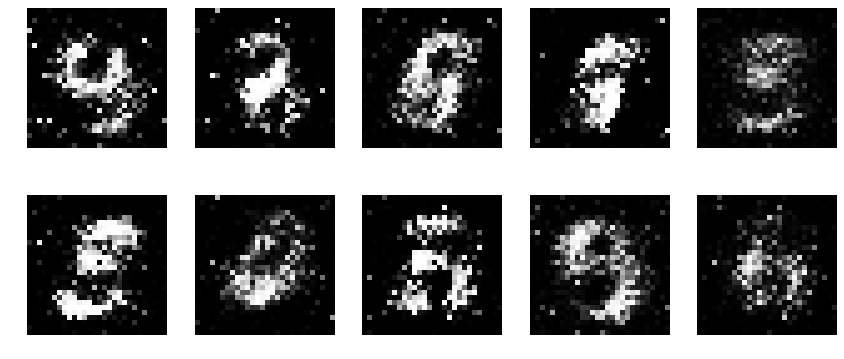

Epoch 82: gl_loss = 0.6644106507301331, dl_loss =0.062227461487054825


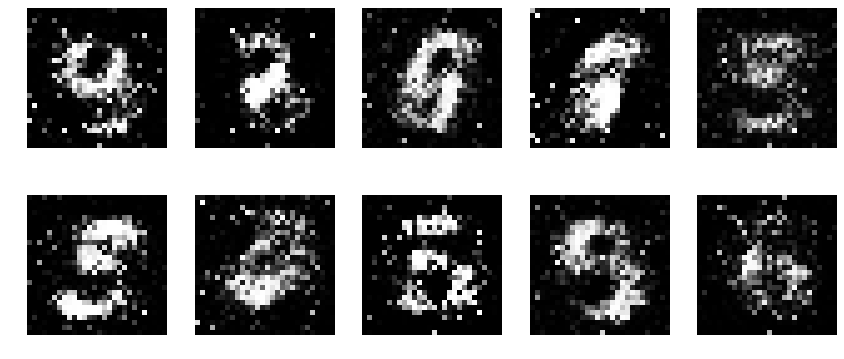

Epoch 83: gl_loss = 0.6698369979858398, dl_loss =0.052177220582962036


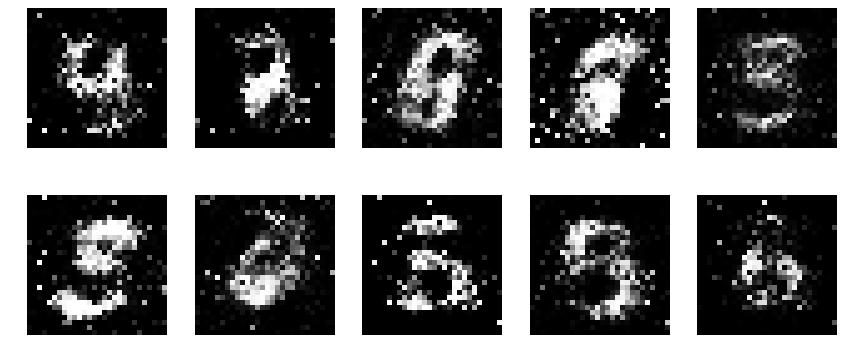

Epoch 84: gl_loss = 0.6726993322372437, dl_loss =0.1686840057373047


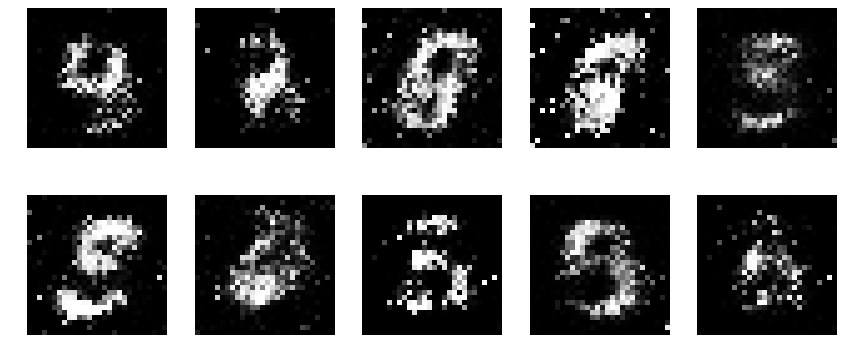

Epoch 85: gl_loss = 0.6516856551170349, dl_loss =0.061468638479709625


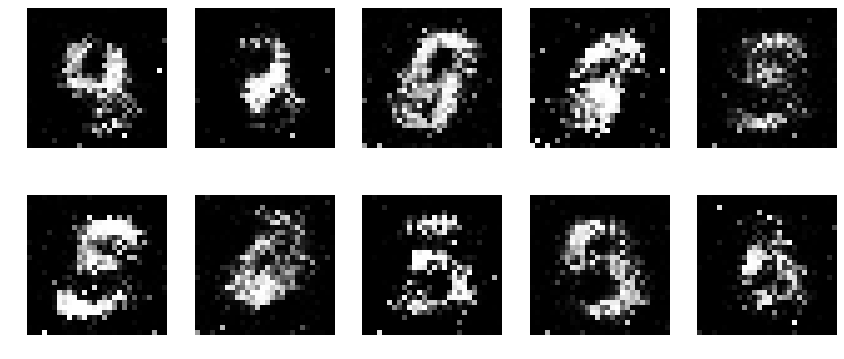

Epoch 86: gl_loss = 0.6771259307861328, dl_loss =0.08787503838539124


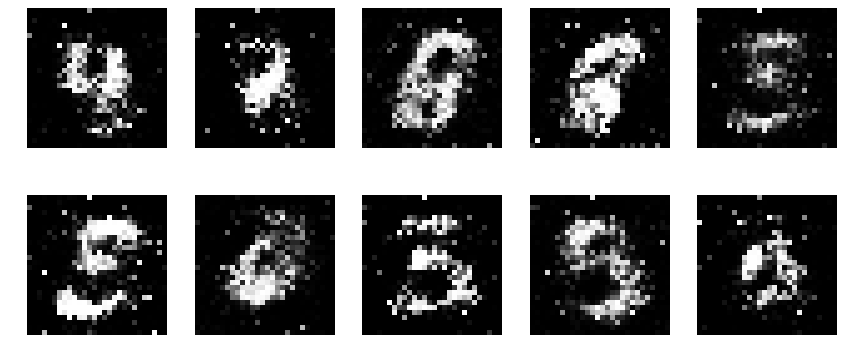

Epoch 87: gl_loss = 0.675585150718689, dl_loss =0.06291042268276215


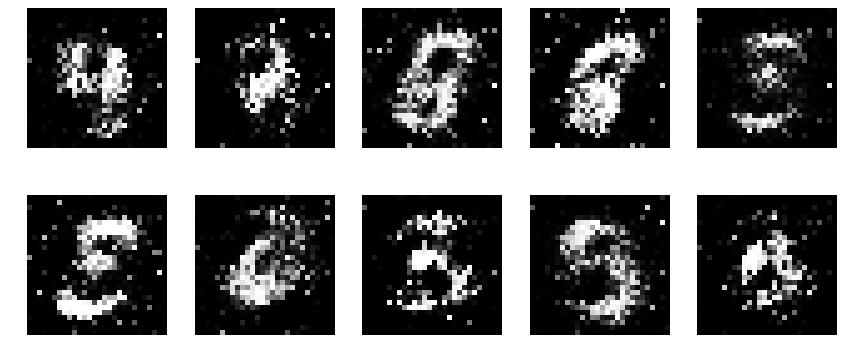

Epoch 88: gl_loss = 0.6645339727401733, dl_loss =0.09514342248439789


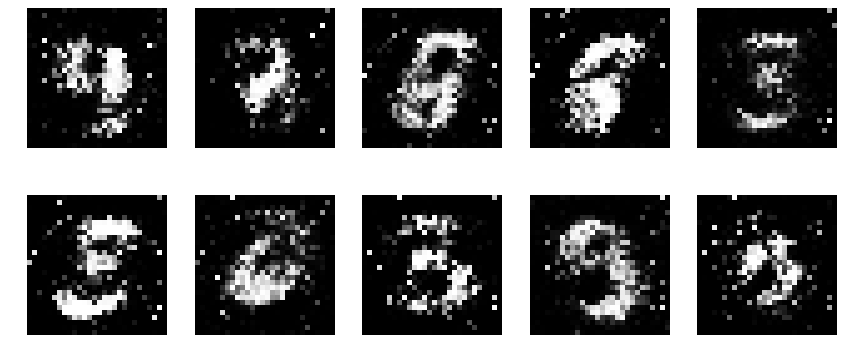

Epoch 89: gl_loss = 0.6531106233596802, dl_loss =0.04630143195390701


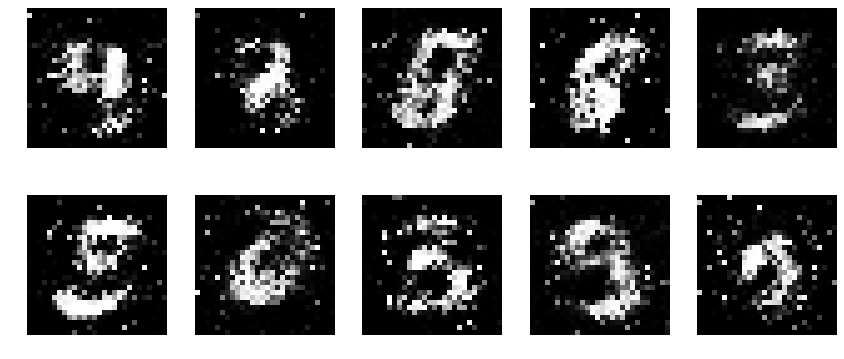

Epoch 90: gl_loss = 0.6658449172973633, dl_loss =0.075550377368927


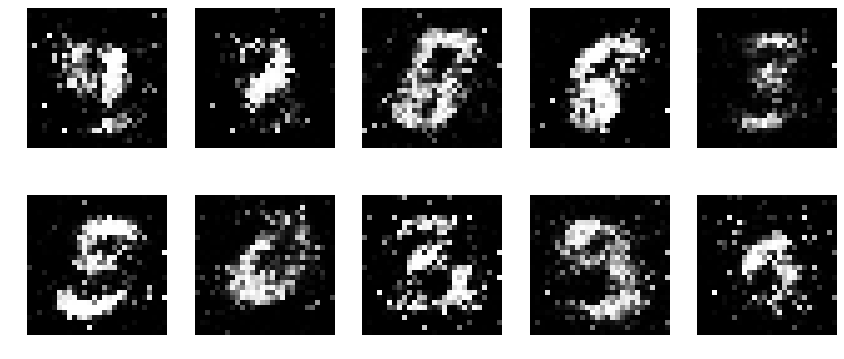

In [ ]:
for i in range (100):
    for j in range(mydata.total_batches):
        batch = mydata.get_batch()
        noise = np.random.normal(size=[BATCH_SIZE,latent_dims])
        gl_val,dl_val,_,__ = sess.run([gen_loss,dis_loss,gen_train,dis_train],feed_dict={z:noise, x:batch})
    disLoss_his.append(dl_val)
    genLoss_his.append(gl_val)
    print("Epoch {}: gl_loss = {}, dl_loss ={}".format(i,gl_val,dl_val))
    show_sample(test_noise)
    plt.pause(1e-12)

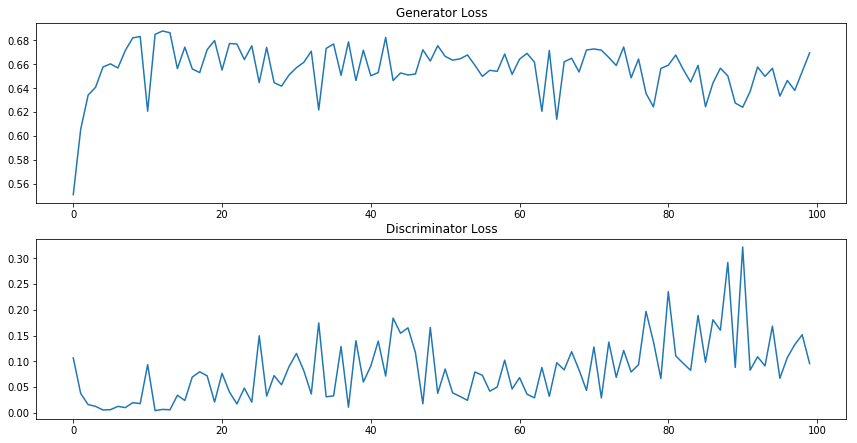

In [15]:
plt.subplot(211)
plt.plot(genLoss_his)
plt.title("Generator Loss")
plt.subplot(212)
plt.plot(disLoss_his)
plt.title("Discriminator Loss")
plt.subplots_adjust(right=2,top=1.5)

In [ ]:
sess.close()